In [7]:
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import backend as K

In [8]:
#create the model and load in the pretrained weigths 
def buildmodel():
    img_width, img_height = 150, 150

    train_data_dir = 'dataset/train'
    validation_data_dir = 'dataset/validation'

    epochs = 50
    batch_size = 16

    if K.image_data_format() == 'channels_first':
        input_shape = (3, img_width, img_height)
    else:
        input_shape = (img_width, img_height, 3)

    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.load_weights('second_try.h5')
    model2 = cv2.dnn.readNetFromCaffe('deploy.prototxt.txt', 
                                 'res10_300x300_ssd_iter_140000.caffemodel')
    return model,model2


In [9]:
#process the image before feeding it into the model for prediction
def process(image_path):
    img_width, img_height = 150, 150

    img = load_img(image_path,False,target_size=(img_width,img_height))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    return x

In [10]:
#detect the face, extract it from the image and pass it through the face mask classifier 
def detectandshow(path,conf,model,model2):
    CONF_THR = conf
    img=(cv2.imread(path))
    outimg=img.copy()
    h, w = img.shape[0:2]
    blob = cv2.dnn.blobFromImage(img, 1, (300*w//h,300), (104,177,123), False)
    model2.setInput(blob)
    output = model2.forward()
    
    for i in range(output.shape[2]):
        conf = output[0,0,i,2]
        if conf > CONF_THR:
            label = output[0,0,i,1]
            x0,y0,x1,y1 = (output[0,0,i,3:7] * [w,h,w,h]).astype(int)
            box = output[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
            face = img[startY:endY, startX:endX]
            if not face.any():
                pass
            else:
                cv2.imwrite('detface.jpg',face)
                read_face=process('detface.jpg')
                preds=model.predict(read_face)
                if preds[0][0]==0:
                    text = "mask"
                    y = startY - 10 if startY - 10 > 10 else startY + 10
                    #print ('masked')
                    cv2.rectangle(outimg, (x0,y0), (x1,y1), (0,0,255), 5)
                    cv2.putText(outimg, text, (startX, y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
                else:
                    text = "no mask"
                    y = startY - 10 if startY - 10 > 10 else startY + 10
                    #print('no mask')
                    cv2.rectangle(outimg, (x0,y0), (x1,y1), (255,0,0), 5)
                    cv2.putText(outimg, text, (startX, y),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255,0,0), 2)
 
    plt.imshow(outimg[:,:,[2,1,0]], aspect='auto')
    plt.show()
    
    return outimg
    
    

In [11]:
#build the model for prediction and pass it along with the path to image as well as the confidence for face detection

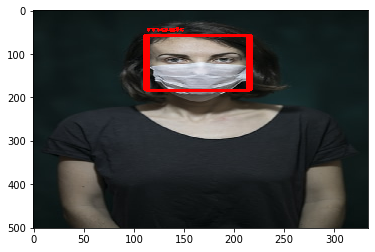

In [12]:
model,model2=buildmodel()
img=detectandshow("masked_woman.jpeg",0.15,model,model2)

In [8]:
cv2.imwrite('predictedsample1.jpg',img)

True

In [35]:
#press any key to exit
cv2.imshow('img',img)
cv2.waitKey(0)
cv2.destroyAllWindows()